In [1]:
import pandas as pd
import re
from gensim import corpora, models, similarities
import csv
import nltk
from nltk.tag.stanford import POSTagger
from nltk.stem.snowball import EnglishStemmer
import matplotlib.pyplot as plt
%matplotlib inline 
from nltk.corpus import stopwords
import compute_fleiss
from collections import Counter

In [2]:
st = POSTagger('../util/stanford-postagger-2014-08-27/models/english-left3words-distsim.tagger',\
               '../util/stanford-postagger-2014-08-27/stanford-postagger-3.4.1.jar')

In [3]:
stemmer = EnglishStemmer()

In [36]:
f = '../data/ao3_work_sherlock_all_2.csv'

In [28]:
f2 = '../data/ao3_work_sherlock_all_1000_2000.csv.bak.bak.bak'

In [5]:
d1 = '/Users/jingy/Desktop/socal/adj_dictionary1.11.txt'
d2 = '/Users/jingy/Desktop/socal/adv_dictionary1.11.txt'
d3 = '/Users/jingy/Desktop/socal/int_dictionary1.11.txt'
d4 = '/Users/jingy/Desktop/socal/noun_dictionary1.11.txt'
d5 = '/Users/jingy/Desktop/socal/verb_dictionary1.11.txt'

In [6]:
df_adj = pd.read_csv(d1, sep = '\t')
df_adv = pd.read_csv(d2, sep = '\t')
df_int = pd.read_csv(d3, sep = '\t')
df_noun = pd.read_csv(d4, sep = '\t')
df_verb = pd.read_csv(d5, sep = '\t')

In [7]:
adj = dict(zip(df_adj[df_adj.columns[0]], df_adj[df_adj.columns[1]]))
adv= dict(zip(df_adv[df_adv.columns[0]], df_adv[df_adv.columns[1]]))
inte = dict(zip(df_int[df_int.columns[0]], df_int[df_int.columns[1]]))
noun = dict(zip(df_noun[df_noun.columns[0]], df_noun[df_noun.columns[1]]))
verb = dict(zip(df_verb[df_verb.columns[0]], df_verb[df_verb.columns[1]]))

In [8]:
def get_senti_score2(word):
#     try:
    word_stem = stemmer.stem(word)
    scores = []
    scores.append(adj.get(word, None))
    scores.append(adj.get(word_stem, None))
    scores.append(adv.get(word, None))
    scores.append(adv.get(word_stem, None))
    scores.append(noun.get(word, None))
    scores.append(noun.get(word_stem, None))
    scores.append(verb.get(word, None))
    scores.append(verb.get(word_stem, None))
#     scores.append(inte.get(word, None))
#     scores.append(inte.get(word_stem, None))
    scores = [i for i in scores if i is not None]
    score = float(sum(scores))/len(scores) if len(scores) != 0 else 0
#     except:
#         score = 0
    return score 

In [9]:
def create_text(df):
    titles = df.Title.drop_duplicates()
    works = []
    for title in titles:
        text = df[df.Title == title].Text.tolist()
        characters = df[df.Title == title].Characters.tolist()
        characters_list = []
        characters_list.append(''.join([part.replace(',', '') for name in characters for part in name ]))if characters != [] else []
        characters_list = [i for i in characters_list[0].split(' ') if i != 'Sherlock' and i != 'Holmes' and i != ''] if characters_list != [] else []
        single_work = []
        for i in text:
            for j in str(i).split('.'):
                if characters_list != []:
                    if 'Sherlock' in j and [c not in j for c in characters_list]:
                        single_work.append(j)
                else:
                    if 'Sherlock' in j:
                        single_work.append(j)
        works.append(single_work)
    return works

In [10]:
def get_works_score(works):
    works_score = []
    for work in works:
        scores = []
        for lines in work:
            for word in lines.split(' '):
                word = ''.join([i for i in word if i.isalpha()])
                word = word.lower()      
                scores.append(get_senti_score2(word))
        if scores != None:
            num_scores = len([i for i in scores if i != 0])
            ave_score = float(sum(scores))/num_scores if num_scores != 0 else None
        works_score.append(ave_score)
    works_score_valid = [i for i in works_score if i is not None]
    return works_score

In [ ]:
def get_rating_categories(scores):
#     r_n5_n4 = len([i for i in works_score_valid if -5 <= i < -4])
#     r_n4_n3 = len([i for i in works_score_valid if -4 <= i < -3])
#     r_n3_n2 = len([i for i in works_score_valid if -3 <= i < -2])
#     r_n2_n1 = len([i for i in works_score_valid if -2 <= i < -1])
#     r_n1_0 = len([i for i in works_score_valid if -1 <= i < 0])
#     r_0_1 = len([i for i in works_score_valid if 0 <= i < 1])
#     r_1_2 = len([i for i in works_score_valid if 1 <= i < 2])
#     r_2_3 = len([i for i in works_score_valid if 2 <= i < 3])
#     r_3_4 = len([i for i in works_score_valid if 3 <= i < 4])
#     r_4_5 = len([i for i in works_score_valid if 4 <= i < 5])
#     ratings = [r_n5_n4, r_n4_n3, r_n3_n2, r_n2_n1, r_n1_0, r_0_1, r_1_2, r_2_3, r_3_4, r_4_5]
    pos = len([i for i in works_score_valid if i > 0])
    neg = len([i for i in works_score_valid if i < 0])
    neu = len([i for i in works_score_valid if i == 0])
    ratings = [pos, neg, neu]
    return ratings

In [105]:
def create_df_time(df, time):
    return df[df.PublishDate.str[:7] == time]

In [37]:
df = pd.read_csv(f)

In [29]:
df2 = pd.read_table(f2,sep = ',')

/Users/jingy/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (3,7,10,11,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [39]:
df_all = pd.concat([df, df2])

In [40]:
len(df_all)

150159

In [66]:
df_all.sort('PublishDate').head(1)

,Additional_Tags,Archive_Warnings,Author,Bookmarks,Category,Chapters,Characters,Comments,CompleteDate,Fandoms,...,Kudos,Language,Notes,PublishDate,Rating,Relationship,Summary,Text,Title,Words
81757,"Drabble Collection, Angst and Humor",Creator Chose Not To Use Archive Warnings,Taz,1,NaN,27/27,"Duncan MacLeod, Methos, Ares, Iphicles, James...",11,2014-09-30,Highlander: The SeriesHercules: The Legendary ...,...,56,English,(See the end of the chapter for not...,2009-12-26,General Audiences,"Duncan MacLeod/Methos, Ares/Iphicles, Dean Wi...",NaN,“He was found in a sub-basement with no identi...,Writing Prompt Drabbles,2701


In [109]:
df_all.head(1)

,Additional_Tags,Archive_Warnings,Author,Bookmarks,Category,Chapters,Characters,Comments,CompleteDate,Fandoms,...,Kudos,Language,Notes,PublishDate,Rating,Relationship,Summary,Text,Title,Words
0,"zombie apocalypse AU, a bit like The Walking ...",Creator Chose Not To Use Archive Warnings,thewallflower07,1,NaN,1/1,"Sherlock Holmes, John Watson, Molly Hooper, G...",2,NaN,Sherlock (TV),...,23,English,"The dialogue and speech thing is intentional, ...",2015-11-07,Teen And Up Audiences,"Sherlock Holmes& John Watson, Molly Hooper/Gr...",What the end of the world means and how you su...,AAAThe quickest way of ending a war is to lose...,The End of the World,2468


In [98]:
timelist = df_all.PublishDate.drop_duplicates().tolist()
timelist = [str(i)[:7] for i in timelist]
timelist = list(set(timelist))
timelist = sorted(timelist)

In [102]:
timelist = timelist[0:56]

In [17]:
df_l = df[['PublishDate','Text','Title', 'Characters']]

In [18]:
df_l = df_l[df_l.Characters.notnull()]
df_l = df_l[df_l.PublishDate != 'PublishDate']
df_l = df_l[df_l.PublishDate.notnull()]
df_l = df_l.sort('PublishDate')

In [247]:
kappas2 = []
for i in timelist:
    df_time = create_df_time(df_l, i)
    if len(df_time) > 0:
        works = create_text(df_time)
        works_score_valid = get_works_score(works)
        ratings = get_rating_categories(works_score_valid)
        kappa = computeKappa([ratings])
        kappas2.append(kappa)

In [106]:
time_work = {}
for i in timelist:
    df_time = create_df_time(df_all, i)
    time_work[i] = len(df_time.groupby(df_time.Title))

In [107]:
time_work

{'2009-12': 1,
 '2010-09': 1,
 '2010-10': 1,
 '2011-02': 0,
 '2011-03': 1,
 '2011-06': 2,
 '2011-09': 1,
 '2011-11': 1,
 '2011-12': 3,
 '2012-01': 4,
 '2012-02': 6,
 '2012-03': 5,
 '2012-04': 13,
 '2012-05': 8,
 '2012-06': 12,
 '2012-07': 15,
 '2012-08': 10,
 '2012-09': 11,
 '2012-10': 17,
 '2012-11': 19,
 '2012-12': 22,
 '2013-01': 40,
 '2013-02': 32,
 '2013-03': 32,
 '2013-04': 46,
 '2013-05': 43,
 '2013-06': 43,
 '2013-07': 80,
 '2013-08': 71,
 '2013-09': 66,
 '2013-10': 88,
 '2013-11': 78,
 '2013-12': 142,
 '2014-01': 244,
 '2014-02': 286,
 '2014-03': 1138,
 '2014-04': 1848,
 '2014-05': 1647,
 '2014-06': 1628,
 '2014-07': 1833,
 '2014-08': 1662,
 '2014-09': 1399,
 '2014-10': 1235,
 '2014-11': 1188,
 '2014-12': 1422,
 '2015-01': 1271,
 '2015-02': 1353,
 '2015-03': 1249,
 '2015-04': 1068,
 '2015-05': 1174,
 '2015-06': 1038,
 '2015-07': 1363,
 '2015-08': 1113,
 '2015-09': 878,
 '2015-10': 963,
 '2015-11': 704}

In [248]:
kappas2

[-0.0009082652134423709,
 -0.000766283524904282,
 -0.0008787346221440945,
 -0.0008271298593880458,
 -0.0009057971014494549,
 -0.0010449320794150149,
 -0.0009319664492077924,
 -0.0010526315789473359,
 -0.0008375209380235438,
 -0.0009920634920633747,
 -0.0012437810945273183,
 -0.0011547344110852823,
 -0.0015600624024961097]

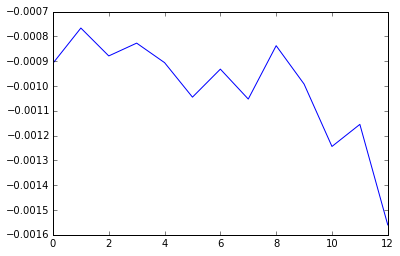

In [249]:
plt.figure()
plt.plot(kappas2)

In [243]:
kappas

[-0.0011235955056180347,
 -0.0009606147934678086,
 -0.00104602510460241,
 -0.0010964912280701932,
 -0.0012106537530266548,
 -0.0013586956521737582,
 -0.0012150668286756265,
 -0.0013831258644534307,
 -0.0010537407797681511,
 -0.001295336787564771,
 -0.0015576323987539784,
 -0.0015503875968991183,
 -0.001980198019802116]

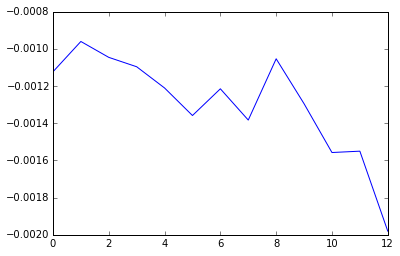

In [245]:
plt.figure()
plt.plot(kappas)

In [274]:
def pos_tag(text):
    return st.tag(text.strip().split(' '))

In [231]:
def get_pos_type(tagged_word):
    pos_tag = str(tagged_word[1])
    if 'JJ' in pos_tag:
        pos_type = 'adj'
    elif 'RB' in pos_tag:
        pos_type = 'adv'
    elif 'NN' in pos_tag:
        pos_type = 'noun'
    elif 'VB' in pos_tag:
        pos_type = 'verb'
    else: 
        pos_type = None
    return (tagged_word[0], pos_type)

In [278]:
def get_senti_score(word, pos):
    word = str(word.lower())
    word_stem = stemmer.stem(word)
    pos = str(pos)
    if pos == 'adj':
        score = adj.get(word, None)
        if score == None:
            score = adj.get(word_stem, None)
    elif pos == 'adv':
        score = adv.get(word, None)
        if score == None:
            score = adv.get(word_stem, None)
    elif pos == 'noun':
        score = noun.get(word, None)
        if score == None:
            score = noun.get(word_stem, None)
    elif pos == 'verb':
        score = verb.get(word, None)
        if score == None:
            score = verb.get(word_stem, None)
    else:
        score = inte.get(word, None)
        if score == None:
            score = inte.get(word_stem, None)
    return word, score

In [318]:
tag_scores = {}
for tag in tags:
    scores = []
    for word in tag.split(' '):
        word = word.lower()       
        scores.append(get_senti_score2(word))
    if scores != None:
        num_scores = len([i for i in scores if i != 0])
        ave_score = float(sum(scores))/num_scores if num_scores != 0 else None
        if ave_score is not None:
            tag_scores[tag] = ave_score

In [62]:
counts = Counter(tags_s)
new_list = sorted(tags_s, key=counts.get, reverse=True)

In [63]:
tag_freq = {i:tags_s.count(i) for i in set(tags_s)}

In [64]:
import operator
sorted_tag_freq = sorted(tag_freq.items(), key=operator.itemgetter(1), reverse = True)

In [65]:
sorted_tag_freq[0:50]

[(' Sherlock Being Sherlock', 388),
 (' POV Sherlock Holmes', 327),
 (' Pining Sherlock', 263),
 (' Virgin Sherlock', 261),
 (' Sherlock Holmes and Feelings', 257),
 (' Established Sherlock Holmes/John Watson', 213),
 (' Sherlock - Freeform', 175),
 (' Omega Sherlock', 152),
 (' Sherlock Loves John', 151),
 (' Alpha Sherlock', 150),
 (' Bottom Sherlock Holmes', 148),
 (' Jealous Sherlock', 148),
 (' Sherlock Is A Bit Not Good', 136),
 (' Top Sherlock', 132),
 (' Possessive Sherlock', 126),
 (' Asexual Sherlock', 119),
 (' John Loves Sherlock', 118),
 (' Kid Sherlock', 109),
 (' Sherlock Holmes - Freeform', 91),
 (' Sherlock AU', 81),
 (' Sherlock-centric', 81),
 (' Sherlock Series 3 Spoilers', 78),
 (' Dark Sherlock', 71),
 (' Sherlock Holmes & John Watson Friendship', 71),
 (" Sherlock's Violin", 71),
 (' Vampire Sherlock', 69),
 (' Sherlock is a Brat', 67),
 (' Insecure Sherlock', 66),
 (' Sad Sherlock', 64),
 (' BBC Sherlock - Freeform', 63),
 (' Bottom Sherlock', 62),
 (' Protectiv

In [43]:
len(df_all.groupby('Title'))

26810

In [44]:
df_distinct = df_all.drop_duplicates('Title')

In [45]:
tags = df_distinct.Additional_Tags.tolist()

In [49]:
tags_s = []
for i in tags:
    tags_s1 = []
    j = str(i).split(',')
    for k in j:
        if 'Sherlock' in k:
            tags_s1.append(k)
    tags_s.append(tags_s1)
# with open ('/Users/jingy/Desktop/sherlock_tags_all2','a') as g:
#     for i in tags_s:
#         g.write(i)
#         g.write('\n')

In [52]:
tags_s = []
for i in tags:
    j = str(i).split(',')
    for k in j:
        if 'Sherlock' in k:
            tags_s.append(k)
tags_s_d = [i for i in tags_s if i != []]

In [319]:
len(tag_scores)

806

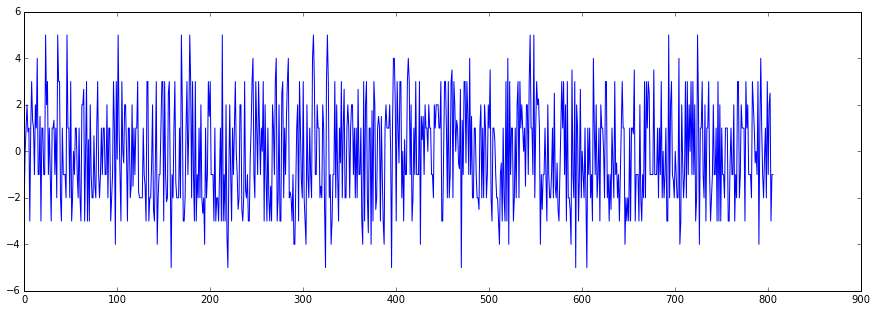

In [327]:
plt.figure(figsize = (15,5))
plt.plot(tag_scores.values())